In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import random
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import transforms
from torch.utils.data import TensorDataset,DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
papset="/kaggle/input/malhari-dataset/Malhari Dataset/Malhari_Dataset_V1/pap"
colset="/kaggle/input/malhari-dataset/Malhari Dataset/Malhari_Dataset_V1/colposcopic"

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),   
])
batch_size = 32

In [39]:
papset1 = datasets.ImageFolder(root=papset, transform=transform)
colset1 = datasets.ImageFolder(root=colset, transform=transform)
pap_dataloader = DataLoader(papset1, batch_size=batch_size, shuffle=True)
col_dataloader = DataLoader(colset1, batch_size=batch_size, shuffle=True)

In [9]:
papdata = datasets.ImageFolder(root=papset, transform=transform) 
class_names = papdata.classes
print("Class names: ",class_names)
print(len(class_names))

Class names:  ['HSIL', 'LSIL', 'NILM', 'SSC']
4


Original shape: torch.Size([3, 256, 256]) -> [color_channels, height, width]
Image permute shape: torch.Size([256, 256, 3]) -> [height, width, color_channels]


(-0.5, 255.5, 255.5, -0.5)

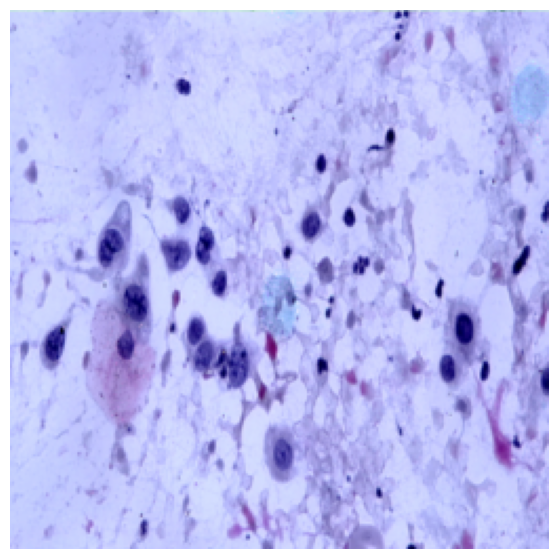

In [11]:
img,label = next(iter(papdata))
img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")

In [14]:
model_path = "/kaggle/input/ganmodel/pytorch/default/1/model.pth"  # Update with the correct path after upload
checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
print(checkpoint.keys())  # Typically contains 'generator', 'discriminator', 'optimizer', etc.

dict_keys(['model', 'optimizer'])


In [ ]:
state_dict = checkpoint["model"]
state_dict

In [ ]:
print(state_dict.keys())

In [18]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_z = nn.Linear(128, 512)  # Latent space mapping

        # Existing upsampling layers
        self.up_8 = nn.Sequential(nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), nn.ReLU())
        self.up_16 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU())
        self.up_32 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU())
        self.up_64 = nn.Sequential(nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU())
        self.up_128 = nn.Sequential(nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), nn.ReLU())
        self.up_256 = nn.Sequential(nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1), nn.ReLU())

        # **NEW: Upsampling to 512x512**
        self.up_512 = nn.Sequential(
            nn.ConvTranspose2d(3, 3, 4, stride=2, padding=1),
            nn.Tanh()  # Normalize outputs to [-1, 1]
        )

    def forward(self, z):
        z = self.init_z(z)
        z = z.view(-1, 512, 1, 1)  # Reshape to 4D tensor

        z = self.up_8(z)
        z = self.up_16(z)
        z = self.up_32(z)
        z = self.up_64(z)
        z = self.up_128(z)
        z = self.up_256(z)
        z = self.up_512(z)  # **New upsampling layer**

        return z  # Final 512x512 image


In [20]:
checkpoint = torch.load(model_path, map_location="cpu")
# Initialize the modified generator
generator = Generator()
# Load weights (strict=False to allow new layers)
missing_keys, unexpected_keys = generator.load_state_dict(checkpoint["model"], strict=False)
# Print mismatched layers
print("Missing keys (new layers not in checkpoint):", missing_keys)
print("Unexpected keys (not used in new model):", unexpected_keys)

Missing keys (new layers not in checkpoint): ['init_z.weight', 'init_z.bias', 'up_8.0.weight', 'up_8.0.bias', 'up_16.0.weight', 'up_16.0.bias', 'up_32.0.weight', 'up_32.0.bias', 'up_64.0.weight', 'up_64.0.bias', 'up_128.0.weight', 'up_128.0.bias', 'up_256.0.weight', 'up_256.0.bias', 'up_512.0.weight', 'up_512.0.bias']
Unexpected keys (not used in new model): ['cls_map_net.net.0.bias', 'cls_map_net.net.0.weight_orig', 'cls_map_net.net.0.weight_u', 'cls_map_net.net.0.weight_v', 'cls_map_net.net.2.bias', 'cls_map_net.net.2.weight_orig', 'cls_map_net.net.2.weight_u', 'cls_map_net.net.2.weight_v', 'cls_map_net.net.4.bias', 'cls_map_net.net.4.weight_orig', 'cls_map_net.net.4.weight_u', 'cls_map_net.net.4.weight_v', 'cls_map_net.net.6.bias', 'cls_map_net.net.6.weight_orig', 'cls_map_net.net.6.weight_u', 'cls_map_net.net.6.weight_v', 'se_8_64.to_context.weight_orig', 'se_8_64.to_context.weight_u', 'se_8_64.to_context.weight_v', 'se_8_64.transform.0.weight_orig', 'se_8_64.transform.0.weight_u',

In [21]:
import torch
import torch.nn as nn
from torch.nn.utils import spectral_norm


# -----------------------------------------------
#            Weights Initialization
# -----------------------------------------------

def weights_init(net, init_type='xavier', init_gain=0.02):
    """Initialize network weights.
    Parameters:
        net (network)       -- network to be initialized
        init_type (str)     -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)   -- scaling factor for normal, xavier and orthogonal.
    """

    def init_func(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 or classname.find('Linear') != -1:
            # Weight
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            # Bias
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

    # Apply the initialization function <init_func>
    net.apply(init_func)


# -----------------------------------------------
#            Spectral Normalization
# -----------------------------------------------

def SN_Conv2d(*args, **kwargs):
    return spectral_norm(nn.Conv2d(*args, **kwargs), eps=1e-04)


def SN_ConvTranspose2d(*args, **kwargs):
    return spectral_norm(nn.ConvTranspose2d(*args, **kwargs), eps=1e-04)


def SN_Linear(*args, **kwargs):
    return spectral_norm(nn.Linear(*args, **kwargs), eps=1e-04)


# -----------------------------------------------
#                 Basic Modules
# -----------------------------------------------

class CondEmbedSequential(nn.Sequential):
    """
    This sequential module composes of different modules and calls them with the matching signatures.
    """
    def forward(self, x, cond):
        for layer in self:
            if isinstance(layer, AdaIN):
                x = layer(x, cond)
            else:
                x = layer(x)
        return x


# Class embedding network
class EmbeddingNetwork(nn.Module):
    def __init__(self, n_class: int, cond_size: int, n_layer: int = 4):
        super().__init__()
        layers = []
        for i in range(n_layer):
            if i == 0:
                layers.append(SN_Linear(n_class, cond_size))
            else:
                layers.append(SN_Linear(cond_size, cond_size))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.net = nn.Sequential(*layers)

    def forward(self, label: torch.tensor):
        return self.net(label)


# Adaptive instance normalization
class AdaIN(nn.Module):
    def __init__(self, num_features: int, cond_size: int):
        super().__init__()
        # Parameter-free normalization
        self.param_free_norm = nn.InstanceNorm2d(num_features, affine=False)

        # Affine transform using condition
        self.affine_cond = SN_Linear(cond_size, num_features * 2)

    def forward(self, x: torch.tensor, cond: torch.tensor):
        """
        :param x: is the input feature map with shape `[batch_size, channels, height, width]`
        :param cond: is the condition embeddings with shape `[batch_size, cond_size]`
        """
        # Normalization
        norm = self.param_free_norm(x)

        # Scaling and bias factors
        h = self.affine_cond(cond).view(x.shape[0], -1, 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)

        return (1 + gamma) * norm + beta


# Project a 1-dim vector into a 4 × 4 feature map
class InitLayer(nn.Module):
    def __init__(self, nz, channel):
        super().__init__()
        self.init = SN_ConvTranspose2d(nz, channel, 4, 1, 0, bias=False)

    def forward(self, noise):
        noise = noise.view(noise.shape[0], -1, 1, 1)
        return self.init(noise)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, cond_size):
        super().__init__()
        self.main = CondEmbedSequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            AdaIN(in_channels, cond_size),
            nn.LeakyReLU(0.2, inplace=True),
            SN_Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        )

    def forward(self, feat, cond):
        return self.main(feat, cond)


class DownBlockComp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            SN_Conv2d(in_channels, out_channels, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SN_Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        )
        self.shortcut = nn.Sequential(
            nn.AvgPool2d(2, 2),
            SN_Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
        )

    def forward(self, feat):
        return self.main(feat) + self.shortcut(feat)


# Skip-Layer Global Context (SGC) Block
class SGCBlock(nn.Module):
    def __init__(self, ch_in, ch_out, r=4):
        super().__init__()
        self.to_context = SN_Conv2d(ch_in, 1, 1, 1, 0, bias=False)
        self.transform = nn.Sequential(
            SN_Conv2d(ch_in, ch_out // r, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            SN_Conv2d(ch_out // r, ch_out, 1, 1, 0, bias=False),
        )

    def forward(self, feat_small, feat_big):
        # Context modeling
        context = self.to_context(feat_small).flatten(2).softmax(dim=-1)
        out = torch.einsum('bin, bcn -> bci', context, feat_small.flatten(2)).unsqueeze(-1)

        # Transform and fusion
        return feat_big + self.transform(out)


# Upsample layer of simple decoder
class SimDec_UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimDec_UpBlock, self).__init__()
        self.main = nn.Sequential(
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            SN_Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        )

    def forward(self, feat):
        return self.main(feat)


# Simple decoder (auxiliary branch of discriminator)
class SimpleDecoder(nn.Module):
    """ A Simple Decoder for self-supervised reconstruction in Discriminator"""
    def __init__(self, nfc_in, nc=3):
        super().__init__()

        # Feature channels at each spatial resolution
        nfc_multi = {16: 4, 32: 2, 64: 2, 128: 1}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v * 32)

        # Decoder structure
        self.main = nn.Sequential(
            nn.AdaptiveAvgPool2d(8),
            SimDec_UpBlock(nfc_in, nfc[16]),
            SimDec_UpBlock(nfc[16], nfc[32]),
            SimDec_UpBlock(nfc[32], nfc[64]),
            SimDec_UpBlock(nfc[64], nfc[128]),
            SN_Conv2d(nfc[128], nc, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, feat):
        return self.main(feat)

In [22]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nc=3, nz=128, ngf=32, n_class=5, d_cond=128, n_layer=4):
        super().__init__()

        # Feature channels at each spatial resolution
        nfc_multi = {4: 16, 8: 16, 16: 8, 32: 8, 64: 4, 128: 2, 256: 1, 512: 1}  # Added 512
        nfc = {k: int(v * ngf) for k, v in nfc_multi.items()}

        # Class embedding network (for conditioning)
        self.cls_map_net = EmbeddingNetwork(n_class, d_cond, n_layer)

        # Initial latent space projection
        self.init_z = InitLayer(nz, channel=nfc[4])

        # Progressive upsampling
        self.up_8 = UpBlock(nfc[4], nfc[8], d_cond)
        self.up_16 = UpBlock(nfc[8], nfc[16], d_cond)
        self.up_32 = UpBlock(nfc[16], nfc[32], d_cond)
        self.up_64 = UpBlock(nfc[32], nfc[64], d_cond)
        self.up_128 = UpBlock(nfc[64], nfc[128], d_cond)
        self.up_256 = UpBlock(nfc[128], nfc[256], d_cond)

        # **New UpBlock for 512x512 Resolution**
        self.up_512 = UpBlock(nfc[256], nfc[512], d_cond)

        # Squeeze-Excitation Attention Mechanisms
        self.se_8_64 = SGCBlock(nfc[8], nfc[64])
        self.se_16_128 = SGCBlock(nfc[16], nfc[128])
        self.se_32_256 = SGCBlock(nfc[32], nfc[256])

        # Final output layer
        self.to_out = nn.Sequential(
            SN_Conv2d(nfc[512], nc, 3, 1, 1, bias=False),  # Updated for 512
            nn.Tanh(),
        )

    def class_embed(self, label):
        return self.cls_map_net(label)

    def generate(self, z, cond):
        feat_4 = self.init_z(z)
        feat_8 = self.up_8(feat_4, cond)
        feat_16 = self.up_16(feat_8, cond)
        feat_32 = self.up_32(feat_16, cond)
        feat_64 = self.se_8_64(feat_8, self.up_64(feat_32, cond))
        feat_128 = self.se_16_128(feat_16, self.up_128(feat_64, cond))
        feat_256 = self.se_32_256(feat_32, self.up_256(feat_128, cond))

        # **New 512x512 UpBlock**
        feat_512 = self.up_512(feat_256, cond)
        
        img = self.to_out(feat_512)
        return img

    def forward(self, z, label):
        cond = self.cls_map_net(label)
        img_out = self.generate(z, cond)
        return img_out


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random




class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=32, n_class=5, recon_mode='l1'):
        super().__init__()
        
        # Feature channels at each spatial resolution
        nfc_multi = {8: 16, 16: 8, 32: 8, 64: 4, 128: 2, 256: 1}
        nfc = {}
        for k, v in nfc_multi.items():
            nfc[k] = int(v * ndf)

        # Network structure
        self.down_256 = SN_Conv2d(nc, nfc[256], 3, 1, 1, bias=False)
        self.down_128 = DownBlockComp(nfc[256], nfc[128])
        self.down_64 = DownBlockComp(nfc[128], nfc[64])
        self.down_32 = DownBlockComp(nfc[64], nfc[32])
        self.down_16 = DownBlockComp(nfc[32], nfc[16])
        self.down_8 = DownBlockComp(nfc[16], nfc[8])
        self.to_logits = SN_Conv2d(nfc[8], 1, 1, 1, 0, bias=False)

        # Projection head
        self.to_cls_embed = SN_Linear(n_class, nfc[8], bias=False)

        # Self-supervised reconstruction
        self.decoder_part = SimpleDecoder(nfc[16], nc)
        self.decoder_overall = SimpleDecoder(nfc[8], nc)
        if recon_mode == 'l1':
            self.recon_loss = nn.L1Loss()
        elif recon_mode == 'mse':
            self.recon_loss = nn.MSELoss()
        else:
            self.recon_loss = None

    def forward(self, img, label, is_real=True, policy=None):
        # Differentiable data augmentation
        img = DiffAugment(img, policy=policy)

        # Main branch
        feat_256 = self.down_256(img)
        feat_128 = self.down_128(feat_256)
        feat_64 = self.down_64(feat_128)
        feat_32 = self.down_32(feat_64)
        feat_16 = self.down_16(feat_32)
        feat_8 = self.down_8(feat_16)
        feat_out = feat_8
        logits = self.to_logits(feat_out)

        # Projection head
        cls_embed = self.to_cls_embed(label).view(label.shape[0], -1, 1, 1)
        logits += torch.sum(cls_embed * feat_out, dim=1, keepdim=True)

        # Self-supervision
        if is_real and self.recon_loss is not None:
            # Crop real image and 16×16 featur map on same portion
            img_part, feat_16_part = random_crop(img, feat_16)

            # Resize overall real image (keep same with cropped image size)
            img_overall = F.interpolate(img, size=128)

            # Self-supervised reconstruction
            recons_part = self.decoder_part(feat_16_part)
            recons_overall = self.decoder_overall(feat_8)

            # Calculate auxiliary reconstruction loss
            aux_loss_16 = self.recon_loss(recons_part, img_part)
            aux_loss_8 = self.recon_loss(recons_overall, img_overall)
            aux_loss = aux_loss_16 + aux_loss_8
        else:
            aux_loss = 0

        return {'logits': logits, 'aux_loss': aux_loss}


# Crop the same part from image and its feature map
def random_crop(image, feat, img_size=128):
    # Crop part of image
    img_h, img_w = image.shape[2:]
    img_ch = random.randint(0, img_h - img_size - 1)
    img_cw = random.randint(0, img_w - img_size - 1)
    img_part = image[:, :, img_ch:img_ch + img_size, img_cw:img_cw + img_size]

    # Crop part of feature map on the same portion
    feat_h, feat_w = feat.shape[2:]
    feat_part_h = int(img_size * feat_h / img_h)
    feat_part_w = int(img_size * feat_w / img_w)
    feat_ch = int(img_ch * feat_h / img_h)
    feat_cw = int(img_cw * feat_w / img_w)
    feat_part = feat[:, :, feat_ch:feat_ch + feat_part_h, feat_cw:feat_cw + feat_part_w]

    return img_part, feat_part

In [27]:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://arxiv.org/pdf/2006.10738

import torch
import torch.nn.functional as F


def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

updated

In [25]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nc=3, nz=128, ngf=32, n_class=5, d_cond=128, n_layer=4):
        super().__init__()

        # Feature channels at each spatial resolution
        nfc_multi = {4: 16, 8: 16, 16: 8, 32: 8, 64: 4, 128: 2, 256: 1, 512: 1}  # Added 512
        nfc = {k: int(v * ngf) for k, v in nfc_multi.items()}

        # Class embedding network (for conditioning)
        self.cls_map_net = EmbeddingNetwork(n_class, d_cond, n_layer)

        # Initial latent space projection
        self.init_z = InitLayer(nz, channel=nfc[4])

        # Progressive upsampling
        self.up_8 = UpBlock(nfc[4], nfc[8], d_cond)
        self.up_16 = UpBlock(nfc[8], nfc[16], d_cond)
        self.up_32 = UpBlock(nfc[16], nfc[32], d_cond)
        self.up_64 = UpBlock(nfc[32], nfc[64], d_cond)
        self.up_128 = UpBlock(nfc[64], nfc[128], d_cond)
        self.up_256 = UpBlock(nfc[128], nfc[256], d_cond)

        # **New UpBlock for 512x512 Resolution**
        self.up_512 = UpBlock(nfc[256], nfc[512], d_cond)

        # Squeeze-Excitation Attention Mechanisms
        self.se_8_64 = SGCBlock(nfc[8], nfc[64])
        self.se_16_128 = SGCBlock(nfc[16], nfc[128])
        self.se_32_256 = SGCBlock(nfc[32], nfc[256])

        # Final output layer
        self.to_out = nn.Sequential(
            SN_Conv2d(nfc[512], nc, 3, 1, 1, bias=False),  # Updated for 512
            nn.Tanh(),
        )

    def class_embed(self, label):
        return self.cls_map_net(label)

    def generate(self, z, cond):
        feat_4 = self.init_z(z)
        feat_8 = self.up_8(feat_4, cond)
        feat_16 = self.up_16(feat_8, cond)
        feat_32 = self.up_32(feat_16, cond)
        feat_64 = self.se_8_64(feat_8, self.up_64(feat_32, cond))
        feat_128 = self.se_16_128(feat_16, self.up_128(feat_64, cond))
        feat_256 = self.se_32_256(feat_32, self.up_256(feat_128, cond))

        # **New 512x512 UpBlock**
        feat_512 = self.up_512(feat_256, cond)
        
        img = self.to_out(feat_512)
        return img

    def forward(self, z, label):
        cond = self.cls_map_net(label)
        img_out = self.generate(z, cond)
        return img_out


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=32, n_class=5, recon_mode='l1'):
        super().__init__()
        
        # Feature channels at each spatial resolution
        nfc_multi = {8: 16, 16: 8, 32: 8, 64: 4, 128: 2, 256: 1, 512: 1}  # Added 512
        nfc = {k: int(v * ndf) for k, v in nfc_multi.items()}

        # New DownBlock for 512x512
        self.down_512 = SN_Conv2d(nc, nfc[512], 3, 1, 1, bias=False)
        
        self.down_256 = DownBlockComp(nfc[512], nfc[256])  # Connect 512 → 256
        self.down_128 = DownBlockComp(nfc[256], nfc[128])
        self.down_64 = DownBlockComp(nfc[128], nfc[64])
        self.down_32 = DownBlockComp(nfc[64], nfc[32])
        self.down_16 = DownBlockComp(nfc[32], nfc[16])
        self.down_8 = DownBlockComp(nfc[16], nfc[8])
        self.to_logits = SN_Conv2d(nfc[8], 1, 1, 1, 0, bias=False)

    def forward(self, img, label, is_real=True, policy=None):
        img = DiffAugment(img, policy=policy)
        
        # New DownBlock for 512x512
        feat_512 = self.down_512(img)
        feat_256 = self.down_256(feat_512)

        feat_128 = self.down_128(feat_256)
        feat_64 = self.down_64(feat_128)
        feat_32 = self.down_32(feat_64)
        feat_16 = self.down_16(feat_32)
        feat_8 = self.down_8(feat_16)
        feat_out = feat_8
        logits = self.to_logits(feat_out)

        return {'logits': logits}


In [29]:
checkpoint = torch.load(model_path, map_location=device)

generator = Generator()
discriminator = Discriminator()

# Load weights (strict=False allows new layers)
generator.load_state_dict(checkpoint["model"], strict=False)
discriminator.load_state_dict(checkpoint["model"], strict=False)

print("✅ Model loaded successfully with updated layers!")


✅ Model loaded successfully with updated layers!


In [30]:
for param in generator.parameters():
    param.requires_grad = False

# Unfreeze only the last layers (256x256 → 512x512)
for param in generator.up_512.parameters():
    param.requires_grad = True
for param in generator.to_out.parameters():
    param.requires_grad = True

for param in discriminator.parameters():
    param.requires_grad = False
for param in discriminator.down_512.parameters():
    param.requires_grad = True


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

Discriminator(
  (down_512): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (down_256): DownBlockComp(
    (main): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (shortcut): Sequential(
      (0): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (down_128): DownBlockComp(
    (main): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (shortcut): Sequential(
    

In [51]:
print(f"labels dtype: {labels.dtype}")
print(f"real_labels dtype: {real_labels.dtype}")
print(f"fake_labels dtype: {fake_labels.dtype}")

labels dtype: torch.int64
real_labels dtype: torch.float32
fake_labels dtype: torch.float32


In [56]:
# One-hot encode labels (assuming num_classes is known)
num_classes = 4  # Set this to the actual number of classes

# Create a tensor of shape [batch_size, num_classes] where the appropriate index is set to 1
labels_one_hot = torch.zeros(batch_size, num_classes).to(device)

# Ensure labels are of type Long before using them as indices
labels = labels.long()  # Convert the labels to long (if they are not already)

# One-hot encode the labels
labels_one_hot[torch.arange(batch_size).to(device), labels] = 1  # One-hot encode the labels


In [52]:
labels = labels.to(device).float()  # Cast labels to float32 before passing to generator

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming generator and discriminator are already defined and initialized
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Set the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `dataloader` is set up as previously
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Move generator and discriminator to the correct device
generator.to(device)
discriminator.to(device)

# Training Loop
for epoch in range(10):  # Loop for 10 epochs
    for real_images, labels in dataloader:  # Iterate through the DataLoader
        batch_size = real_images.size(0)  # Get the batch size
        
        # Cast the labels to float to match the logits output type
        real_labels = torch.ones(batch_size, 1).to(device).float()  # Real labels = 1
        fake_labels = torch.zeros(batch_size, 1).to(device).float()  # Fake labels = 0

        # Move images and labels to the device (GPU or CPU)
        real_images = real_images.to(device)

        # One-hot encode labels (assuming num_classes is known)
        num_classes = 4  # Set this to the actual number of classes
        labels_one_hot = torch.zeros(batch_size, num_classes).to(device)

        # Ensure labels are of type Long before using them as indices
        labels = labels.long()  # Convert the labels to long (if they are not already)

        # One-hot encode the labels
        labels_one_hot[torch.arange(batch_size).to(device), labels] = 1  # One-hot encode the labels

        # Generate fake images (latent vector input to generator)
        noise = torch.randn(batch_size, 128).to(device)  # Latent vector for generator input
        fake_images = generator(noise, labels_one_hot)  # Generator generates fake images

        # Train Discriminator
        optimizer_D.zero_grad()  # Zero the gradients of the discriminator

        # Real images loss
        real_output = discriminator(real_images, labels_one_hot)["logits"]
        loss_D_real = criterion(real_output, real_labels)

        # Fake images loss
        fake_output = discriminator(fake_images.detach(), labels_one_hot)["logits"]  # Detach fake images to avoid updating generator
        loss_D_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()  # Backpropagate the loss
        optimizer_D.step()  # Update the discriminator

        # Train Generator
        optimizer_G.zero_grad()  # Zero the gradients of the generator

        # Generate fake images and try to fool the discriminator
        output_fake = discriminator(fake_images, labels_one_hot)["logits"]
        loss_G = criterion(output_fake, real_labels)  # We want discriminator to classify fake images as real

        loss_G.backward()  # Backpropagate the generator's loss
        optimizer_G.step()  # Update the generator

    # Optionally, print or save the losses
    print(f"Epoch [{epoch+1}/10], Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4 and 5x128)

In [49]:
class NestedImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom Dataset to handle nested directories within each class.
        Arguments:
        - root_dir: path to the root directory (papset)
        - transform: optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Traverse all the subdirectories in root_dir
        class_label = 0
        for class_name in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                # Traverse all subfolders within this class folder
                for subfolder in os.listdir(class_path):
                    subfolder_path = os.path.join(class_path, subfolder)
                    if os.path.isdir(subfolder_path):
                        # Add images to the list
                        for img_name in os.listdir(subfolder_path):
                            img_path = os.path.join(subfolder_path, img_name)
                            if img_path.endswith(('.jpg', '.png', '.jpeg')):
                                self.image_paths.append(img_path)
                                self.labels.append(class_label)
                class_label += 1

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')  # Open image and convert to RGB

        if self.transform:
            img = self.transform(img)

        return img, label  # Return image and corresponding label


# Define the image transformation (resize, tensor conversion, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to (128, 128) or any desired size
    transforms.ToTensor(),  # Convert image to tensor
])

# Initialize your custom dataset
dataset = NestedImageFolder(root_dir=papset, transform=transform)

# Create DataLoader for batching
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the DataLoader
for real_images, labels in dataloader:
    print("Real Images Shape:", real_images.shape)  # Should be [batch_size, 3, 128, 128]
    print("Labels:", labels)  # Labels for each image in the batch
    break  # Just inspect the first batch


Real Images Shape: torch.Size([32, 3, 128, 128])
Labels: tensor([2, 2, 2, 1, 3, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 1, 3, 1, 2,
        1, 3, 2, 2, 2, 0, 2, 3])


In [32]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
from scipy.linalg import sqrtm
from torch.utils.data import DataLoader
from torch import nn
import os
from PIL import Image

# Load pre-trained InceptionV3 model (without the final softmax layer)
inception_model = torchvision.models.inception_v3(pretrained=True, transform_input=False)
inception_model.eval()

# Helper function to extract features from images using InceptionV3
def get_inception_features(images, model=inception_model, batch_size=32):
    features = []
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),  # Inception requires 299x299 input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Loop through batches of images
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        batch = torch.stack([preprocess(image) for image in batch]).to(device)
        
        with torch.no_grad():
            # Get Inception features (before softmax)
            feature = model(batch)
            feature = feature.detach().cpu().numpy()
            features.append(feature)
    
    return np.concatenate(features)

# FID Calculation Function
def calculate_fid(real_images, generated_images, model=inception_model, batch_size=32):
    real_features = get_inception_features(real_images, model, batch_size)
    fake_features = get_inception_features(generated_images, model, batch_size)

    # Compute mean and covariance of real and fake features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Compute FID score using Fréchet Distance formula
    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))

    # Numeric stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid_score

# Example usage in training loop
for epoch in range(num_epochs):
    for real_images, labels in dataloader:
        # Training code for discriminator and generator here...

        # Calculate FID score periodically (e.g., every epoch or after some epochs)
        if epoch % 10 == 0:
            # Assuming you have a function to get your generated images as a list of PIL Images
            real_images_list = [Image.fromarray(img.numpy()) for img in real_images.cpu().numpy()]
            generated_images_list = [Image.fromarray(img.numpy()) for img in fake_images.cpu().detach().numpy()]
            
            fid = calculate_fid(real_images_list, generated_images_list)
            print(f"FID at epoch {epoch}: {fid}")
